## 分析A/B测试结果


## 目录
- [简介](#intro)
- [I - 概率](#probability)
- [II - A/B 测试](#ab_test)
- [III - 回归](#regression)


<a id='intro'></a>
### 简介

通过notebook 来帮助公司弄清楚他们是否应该使用新的页面，保留旧的页面，或者应该将测试时间延长，之后再做出决定。

<a id='probability'></a>
#### I - 概率

导入库。

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

`1.` 导入 `ab_data.csv` 数据，并将其存储在 `df` 中。
a. 导入数据集，并在这里查看前几行：

In [2]:
df = pd.read_csv('ab-data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. 查找数据集中的行数。

In [3]:
df.shape[0]

294478

c. 数据集中独立用户的数量。

In [4]:
df['user_id'].nunique()

290584

d. 用户转化的比例。

In [5]:
df.query('converted == 1')['user_id'].nunique()/df['user_id'].nunique()

0.12104245244060237

e.  `new_page` 与 `treatment` 不一致的次数。

In [6]:
df.query('(group== "treatment" and landing_page != "new_page") or (group != "treatment" and landing_page == "new_page") ').count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64


f. 是否有任何行存在缺失值？

In [7]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

`2.` 对于 **treatment** 不与 **new_page** 一致的行或 **control** 不与 **old_page** 一致的行，我们不能确定该行是否真正接收到了新的或旧的页面。我们应创建一个符合测试规格要求的新数据集。将新 dataframe 存储在 **df2** 中。

In [8]:
df2 = df.query('(group == "treatment" and landing_page == "new_page") or (group == "control" and landing_page == "old_page")')

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [10]:
df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0]

0

a.  **df2** 中有多少唯一的 **user_id**?

In [11]:
df2['user_id'].nunique()

290584

In [12]:
df2['user_id'].count()

290585

b.  **df2** 中有一个重复的 **user_id** 。它是什么？ 

In [13]:
df2.user_id[df2.user_id.duplicated() == True]

2893    773192
Name: user_id, dtype: int64

c. 这个重复的  **user_id** 的行信息是什么？

In [14]:
df2[df2.duplicated('user_id') == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. 删除 **一个** 含有重复的 **user_id** 的行.

In [15]:
df2 = df2.drop_duplicates(['user_id'])

a. 不管它们收到什么页面，单个用户的转化率是多少？


In [16]:
df2['converted'].mean()

0.11959708724499628

b. 假定一个用户处于 `control` 组中，他的转化率是多少？

In [17]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

c. 假定一个用户处于 `treatment` 组中，他的转化率是多少？


In [18]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

d. 一个用户收到新页面的概率是多少？


In [19]:
df2.query('landing_page == "new_page"').count()[0]/df2.shape[0]

0.5000619442226688

结论：**用户的转化率基本一致，所以我认为当前的页面不能带来更多的转化**

<a id='ab_test'></a>
### II - A/B 测试


**我的假设**

$H_0: P_{old}-P_{new} \ge 0$
我的零假设是旧页面的转化率大于等于新的页面的转化率。

$H_1: P_{old}-P_{new} < 0$
我的备择假设是旧页面的转化率小于新的页面的转化率。

`2.` 假定在零假设中，不管是新页面还是旧页面， $p_{new}$ and $p_{old}$ 都具有等于 **转化** 成功率的“真”成功率，也就是说，  $p_{new}$ 与 $p_{old}$ 是相等的。此外，假设它们都等于**ab_data.csv** 中的 **转化** 率，新旧页面都是如此。  <br><br>

每个页面的样本大小要与 **ab_data.csv** 中的页面大小相同。  <br><br>

执行两次页面之间 **转化** 差异的抽样分布，计算零假设中10000次迭代计算的估计值。  <br><br>

a. 在零假设中，$p_{new}$ 的 **convert rate（转化率）** 


In [20]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. 在零假设中， $p_{old}$  的 **convert rate（转化率）** <br><br>

In [21]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c.  $n_{new}$ 是多少？

In [22]:
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

d.  $n_{old}$?是多少？

In [23]:
n_old = df2.query('group == "control"').shape[0]
n_old

145274

e. 在零假设中，使用 $p_{new}$ 转化率模拟 $n_{new}$ 交易，并将这些 $n_{new}$ 1's 与 0's 存储在 **new_page_converted** 中。

In [24]:
new_page_converted = np.random.choice([0,1], n_new,p=[(1-p_new),p_new])

f. 在零假设中，使用 $p_{old}$ 转化率模拟 $n_{old}$ 交易，并将这些  $n_{old}$ 1's 与 0's 存储在 **old_page_converted** 中。

In [25]:
old_page_converted = np.random.choice([0,1], n_old,p=[(1-p_old),p_old])

g. 在 (e) 与 (f)中找到 $p_{new}$ - $p_{old}$ 模拟值。

In [26]:
new_page_converted.mean()-old_page_converted.mean()

0.0007550778535575647

h. 使用**a. 到 g.**中的计算方法来模拟 10,000个 $p_{new}$ - $p_{old}$ 值，并将这 10,000 个值存储在 **p_diffs** 中。

In [27]:
p_diffs = []
for _ in range(int(1e4)):
    new_page  = np.random.choice([0,1], n_new,p = [(1-p_new),p_new]).mean()
    old_page = np.random.choice([0,1], n_old,p = [(1-p_old),p_old]).mean()
    diffs = new_page-old_page
    p_diffs.append(diffs)

i. 绘制一个 **p_diffs** 直方图。

In [28]:
real_diff = df2.query('group == "treatment"')['converted'].mean() - df2.query('group == "control"')['converted'].mean()
real_diff

-0.0015782389853555567

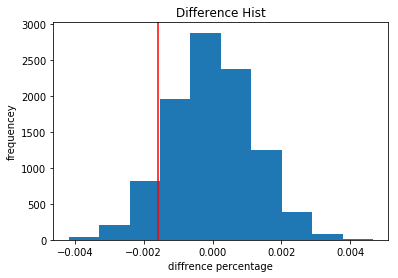

In [29]:
plt.hist(p_diffs)
plt.title('Difference Hist')
plt.xlabel('diffrence percentage')
plt.ylabel('frequencey')
plt.axvline(x = real_diff, color = "r")

j.  在**p_diffs**列表的数值中，有多大比例大于 **ab_data.csv** 中观察到的实际差值？

In [30]:
p_diffs = np.array(p_diffs)
(p_diffs > real_diff).mean()

0.9019

j计算出来的结果为P值，p值为我们在当前df2观测到的结果和更极端的情况发生的概率的总和。当前的p值大于5%，所以我们不拒绝零假设，新旧页面的转化率没有区别。

使用一个内置程序 （built-in）来实现类似的结果。尽管使用内置程序可能更易于编写代码，但上面的内容是对正确思考统计显著性至关重要的思想的一个预排。填写下面的内容来计算每个页面的转化次数，以及每个页面的访问人数。使用 `n_old` 与 `n_new` 分别引证与旧页面和新页面关联的行数。

In [31]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" and converted == 1').count()[0]
convert_new = df2.query('group == "treatment" and converted == 1').count()[0]
n_old = df2.query('group == "control"').count()[0]
n_new = df2.query('group == "treatment"').count()[0]

In [32]:
print(convert_old,convert_new,n_old,n_new)

17489 17264 145274 145310


m. 现在使用 `stats.proportions_ztest` 来计算你的检验统计量与 p-值。[这里](http://knowledgetack.com/python/statsmodels/proportions_ztest/) 是使用内置程序的一个有用链接。

In [33]:
convert = [convert_old,convert_new]
n = [n_old, n_new]
z_score, p_value = sm.stats.proportions_ztest(convert, n,alternative = "smaller")
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

In [34]:
from scipy.stats import norm

z_score_significant = norm.cdf(z_score)
confidence = norm.ppf(1-0.05)
z_score_significant,confidence

(0.9050583127590245, 1.6448536269514722)

**z-score 1.3109241984234394 小于 1.1.6448536269514722，p-value大于0.05，所以转化率差异不显著，与上述结果一致**

<a id='regression'></a>
### III - 回归分析法

`1.` 在最后一部分中，你会看到，你在之前的A / B测试中获得的结果也可以通过执行回归来获取。<br><br>

a. 既然每行的值是转化或不转化，那么在这种情况下，我们应该执行

**逻辑回归。**

使用 **statsmodels** 来拟合你在 **a.** 中指定的回归模型，以查看用户收到的不同页面是否存在显著的转化差异。但是，首先，你需要为这个截距创建一个列（ 原文：column） ，并为每个用户收到的页面创建一个虚拟变量列。添加一个 **截距** 列，一个 **ab_page** 列，当用户接收 **treatment** 时为1， **control** 时为0。

In [35]:
df_new = pd.get_dummies(df2['group'])
df2['ab_page'] = df_new['treatment']
df2['intercept'] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


 导入回归模型。 实例化该模型，并使用在 **b.** 中创建的2个列来拟合该模型，用来预测一个用户是否会发生转化。

In [36]:
log_model = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = log_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [37]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 17 Feb 2019   Pseudo R-squ.:               8.077e-06
Time:                        20:53:05   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

回归模型的零假设是两者相等，备择假设是两者不想等。而P2的零假设是旧页面大于等于新页面转化率，备择假设是旧页面转化率小于新页面转化率。
当前的p值为0.19，与之前的结果不同的原因是因为当前的检验是双边检验，而之前的检验是单边检验。

用户的年龄，职业等因素可能也会影响到用户转化。但如果因素之间相互关联，有较强的相关性的话那么可能无法添加新元素。

除了测试不同页面的转化率是否会发生变化之外，还要根据用户居住的国家或地区添加一个 effect 项。我们导入 **countries.csv** 数据集，并将数据集合并在适当的行上。 

In [38]:
df_c = pd.read_csv("countries.csv")
df_c.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [39]:
df3 = df2.join(df_c.set_index('user_id'), on='user_id')

In [40]:
df_country = pd.get_dummies(df3["country"])
df3 = df3.join(df_country[["US","UK"]])
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,US,UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,1,0


In [41]:
log_mod = sm.Logit(df3["converted"],df3[["intercept","ab_page","US","UK"]])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 17 Feb 2019   Pseudo R-squ.:               2.323e-05
Time:                        20:53:08   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

In [42]:
np.exp(results.params)

intercept    0.131332
ab_page      0.985168
US           1.041599
UK           1.051944
dtype: float64

从系数来看，国家和转化率之间的影响特别小，同时从P值上看也不具备统计显著性，所以国家和转化率上也没有什么相关性。

h. 现在已经查看了国家与页面在转化率上的个体性因素，但现在我们要查看页面与国家/地区之间的相互作用，测试其是否会对转化产生重大影响。创建必要的附加列，并拟合一个新的模型。 

In [43]:
df3['new_US'] = df3['ab_page'] * df3['US']
df3['new_UK'] = df3['ab_page'] * df3['UK']
log_mod = sm.Logit(df3["converted"],df3[["intercept","ab_page","US","UK","new_US","new_UK"]])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sun, 17 Feb 2019   Pseudo R-squ.:               3.482e-05
Time:                        20:53:11   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
new_US         0.0469      0.054      0.872      0.383      -0.059       0.152
new_UK         0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

In [44]:
np.exp(results.params)

intercept    0.134794
ab_page      0.934776
US           1.017682
UK           1.011854
new_US       1.048001
new_UK       1.081428
dtype: float64

In [45]:
1/np.exp(results.params)

intercept    7.418713
ab_page      1.069775
US           0.982625
UK           0.988285
new_US       0.954198
new_UK       0.924703
dtype: float64

我们以CA为基准得出的结果来看，系数之间关联不大，同时P值都显示了不具备统计显著性，所以我们认为国家和页面之间也没有什么相互作用。

根据我们的A/Btest的结论来看，我们建议该电商不需要发布新页面。因为新页面在不同的国家/地区都不会提高转化率。